In [1]:
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch 
import cv2

from IPython.display import Image, clear_output  # to display images
#from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete. Using torch 1.10.1+cu111 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=14964MB, multi_processor_count=40)


In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="UkY7NS1vQBwznjaPqyH3")
project = rf.workspace("w251-khuxx").project("ai-cook-plus-custom-data")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to ai-cook-plus-custom-data-2 in yolov5pytorch:: 100%|██████████| 22882/22882 [00:08<00:00, 2775.83it/s] 


In [3]:
%cat {dataset.location}/data.yaml

names:
- apple
- avocado
- banana
- beef
- blueberries
- bread
- butter
- carrot
- cheese
- chicken
- chicken_breast
- chocolate
- corn
- eggs
- flour
- goat_cheese
- green_beans
- ground_beef
- ham
- heavy_cream
- lime
- milk
- mushrooms
- onion
- potato
- shrimp
- spinach
- strawberries
- sugar
- sweet_potato
- tomato
- tortilla_chip
nc: 32
train: ai-cook-plus-custom-data-2/train/images
val: ai-cook-plus-custom-data-2/valid/images


In [4]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [5]:
!pip install wandb

import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gabrielamaylagunes. Use `wandb login --relogin` to force relogin


True

In [6]:
!python3 train.py --img 640 --batch 32 --epochs 90 --data {dataset.location}/data.yaml --cfg ./models/yolov5m.yaml --weights yolov5m.pt --name aic_sm_m  --cache

wandb: Currently logged in as: gabrielamaylagunes. Use `wandb login --relogin` to force relogin
train: weights=yolov5m.pt, cfg=./models/yolov5m.yaml, data=/home/ubuntu/w251finalyolo5/ai-cook-plus-custom-data-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=90, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=aic_sm_m, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/jmiller558/w251finalyolo5 ✅
YOLOv5 🚀 v6.1-314-g13ae146d Python-3.8.10 torch-1.10.1+cu111 CUDA:0 (Tesla T4, 14964MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warm

In [1]:
!python3 export.py --weights 'runs/train/aic_sm_m2/weights/best.pt' --include onnx

export: data=data/coco128.yaml, weights=['runs/train/aic_sm_m2/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, train=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v6.1-314-g13ae146d Python-3.8.10 torch-1.10.1+cu111 CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 20978205 parameters, 0 gradients, 48.3 GFLOPs

PyTorch: starting from runs/train/aic_sm_m2/weights/best.pt with output shape (1, 25200, 37) (161.1 MB)

ONNX: starting export with onnx 1.12.0...
ONNX: export success, saved as runs/train/aic_sm_m2/weights/best.onnx (80.4 MB)

Export complete (4.29s)
Results saved to /home/ubuntu/w251finalyolo5/runs/train/aic_sm_m2/weights
Detect:          python detect.py --weights runs/train/aic_sm_m2/weights/best.onnx 
Validate:        python val.py --weight

In [1]:
import torch 
import cv2

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = torch.hub.load('/home/ubuntu/w251finalyolo5-gaby', 'custom', path='/home/ubuntu/w251finalyolo5-gaby/runs/train/aic_sm_m2/weights/best.pt', source='local')

YOLOv5 🚀 v6.1-317-g1f7254d7 Python-3.8.10 torch-1.10.1+cu111 CUDA:0 (Tesla T4, 14964MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20978205 parameters, 0 gradients, 48.3 GFLOPs
Adding AutoShape... 


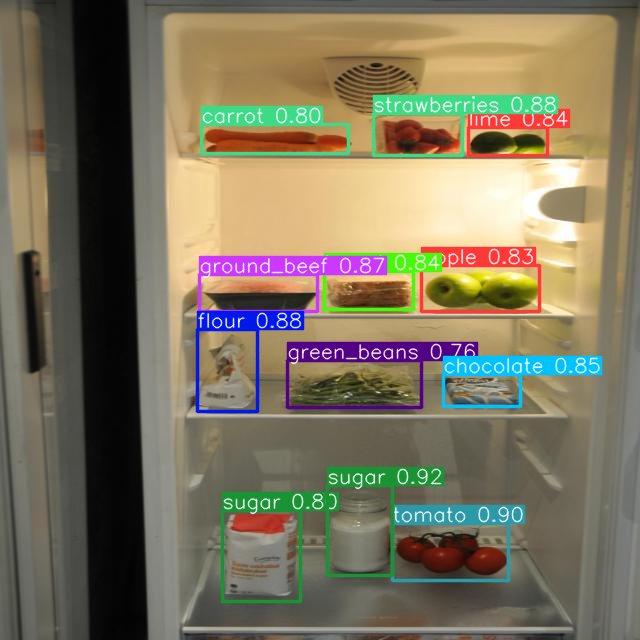

In [4]:
# Define confidence treshold
model.conf = .5

# Get a test image

im2 = cv2.imread('aicook-4/test/images/DSC_5941_JPG_jpg.rf.7f34ef03affd2f952f6519e8506d8cdc.jpg')[..., ::-1]
results = model(im2, size=640)
results.show()

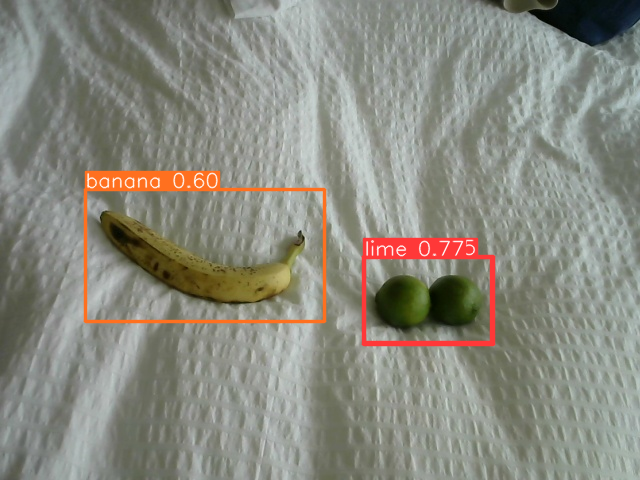

In [5]:
im2 = cv2.imread('/home/ubuntu/w251finalyolo5/test.jpg')[..., ::-1]
results = model(im2, size=640)
results.show()

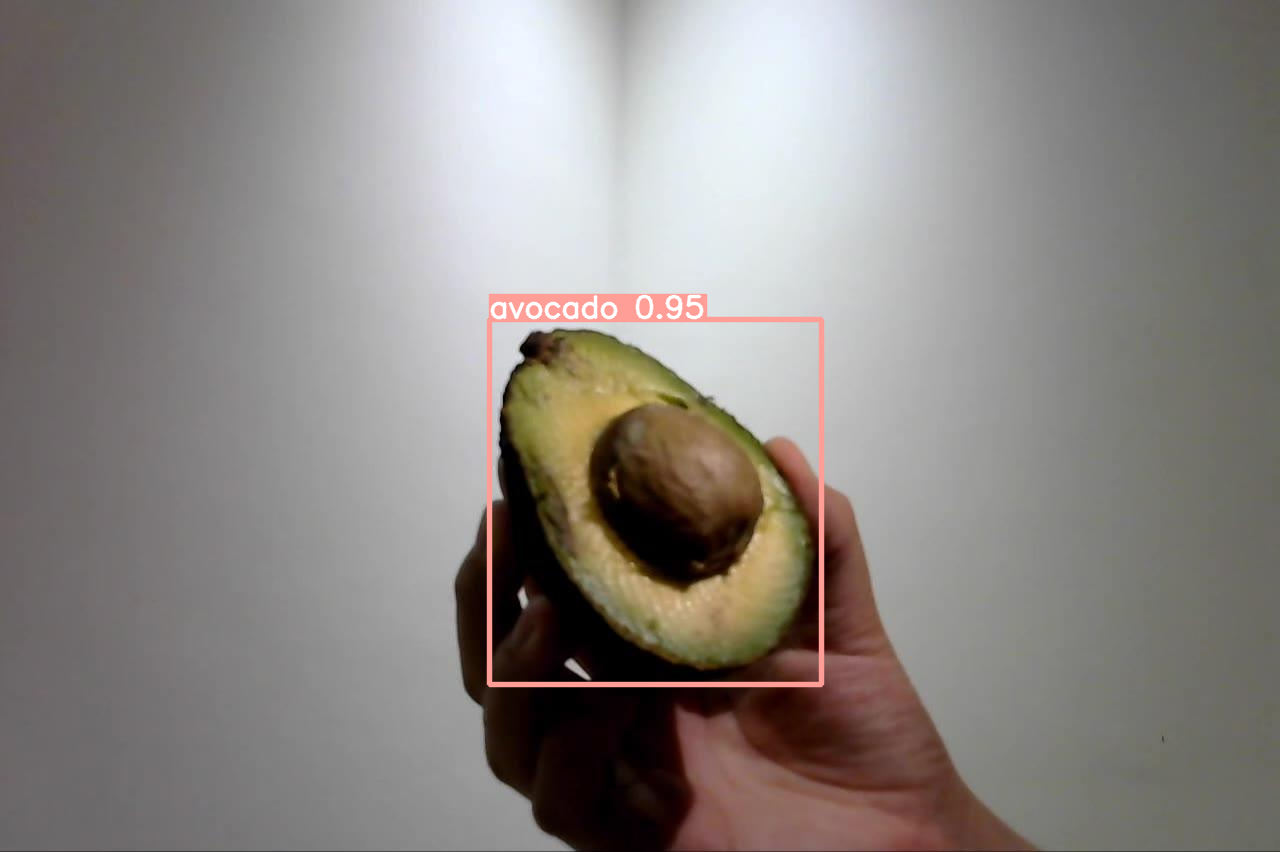

In [6]:
im2 = cv2.imread('/home/ubuntu/w251finalyolo5/test2.jpg')[..., ::-1]
results = model(im2, size=640)
results.show()

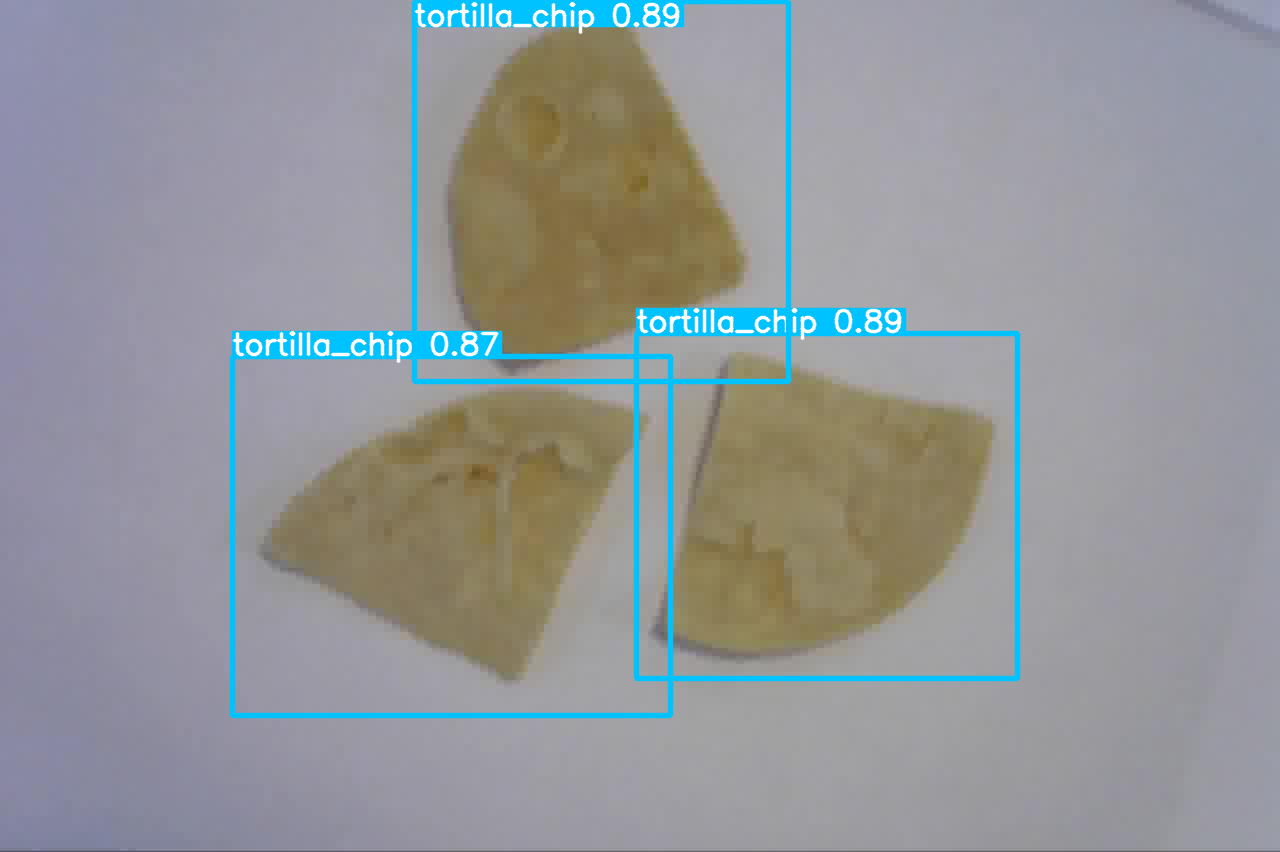

In [7]:
im2 = cv2.imread('/home/ubuntu/w251finalyolo5/test3.jpg')[..., ::-1]
results = model(im2, size=640)
results.show()

In [9]:
!python3 /home/ubuntu/w251finalyolo5-gaby/val.py --weights 'runs/train/aic_sm_m2/weights/best.pt' --data '/home/ubuntu/w251finalyolo5-gaby/ai-cook-plus-custom-data-2/data.yaml' --img 640


val: data=/home/ubuntu/w251finalyolo5-gaby/ai-cook-plus-custom-data-2/data.yaml, weights=['runs/train/aic_sm_m2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-316-gf3d9981e Python-3.8.10 torch-1.10.1+cu111 CUDA:0 (Tesla T4, 14964MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20978205 parameters, 0 gradients, 48.3 GFLOPs
val: Scanning '/home/ubuntu/w251finalyolo5-gaby/ai-cook-plus-custom-data-2/valid
val: New cache created: /home/ubuntu/w251finalyolo5-gaby/ai-cook-plus-custom-data-2/valid/labels.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        896       2545      0.949      0.967      0.969      0.625
               apple        896        437      0.984      0.9